###  Q-learning and Reinforcement learning, FrozenLake, custom grid2

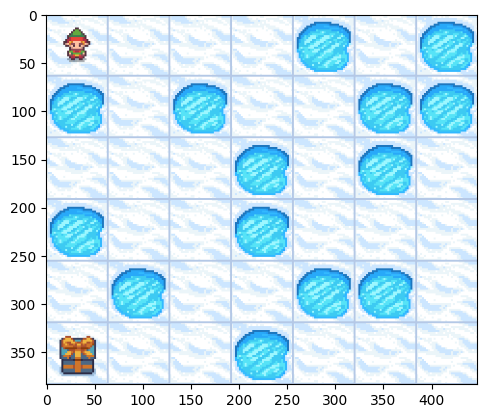

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Here, I defined a custom map, S => start, G => goal, F => normal ice tile, H => hole 
custom_map = [ "SFFFHFH",
               "HFHFFHH",
               "FFFHFHF",
               "HFFHFFF",
               "FHFFHHF",
               "GFFHFFF"]

# create the FrozenLake environment, DISABLE SLIPPERY
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", desc=custom_map)

# it would be logical to have width + height
# we have to double-check that we get the correct values in this order 
grid_height, grid_width  = env.unwrapped.desc.shape

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

env.reset()
plt.imshow(env.render())

In [2]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

# in other words observation space => 4 x 4 grid => 16 cells
# action space => 4 different movements are possible => up, right, down, left

Observation space:
Discrete(42)

Action space:
Discrete(4)


In [3]:
# this is the table that is used in Q-learning
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(42, 4)

In [4]:
# created the function that update the Q-Learning
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

In [5]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_height, grid_width)

In [6]:
# helper variables for our Q-learning training algorithm

# learning rate (alpha) => usually good idea to start with 0.5, if the total rewards 

# gamma => how much the AI values long-term rewards over short-term rewards
# gamma of 0.9 is very typical in basic Q-learning (a mix of short-term and long-rewards)

total_episodes = 10000

# how many steps our agent tries within one episode
# until we give up with that episode
max_steps = 50

learning_rate = 0.5
gamma = 0.9

# epsilon does helps to
# determine how much our agent relies on current knowledge
# and how much the agent does wild guessing while training

# in the beginning of training 
# lots of guessing (high epsilon)
# but towards the end of training 
# then resulted to less guessing and more trusting previous knowledge (smaller epsilon)
# Simply because there is need for guessing in the beginning 
# whichhelps to start the learning
# know the optimal first steps in our current Q-table
epsilon = 0.9

# upper bound of our epsilon
max_epsilon = 0.9

# this is the lower bound, and our code is not going to decay the epsilon below this
min_epsilon = 0.01
decay_rate = 0.0005

### Now, training the agent with a for-loop (based on episodes)

In [7]:
# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # this get the initial state + info-variable (info is not required usually)
    state, info = env.reset()

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    
    # (this example: give up after 50 steps -> probably not optimal route)
    for step in range(max_steps):
        # this is what we need to do:

    
        # here, using the epsilon to decide whether we should trust previous knowledge
        # or take a wild guess
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            action = np.argmax(Q_table[state, :])
        else:
            # the random action
            action = env.action_space.sample()


        # and unpack the results into: observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        
        # this will eventually guide the agent to choose the shortest path with least moves
        reward = reward - 0.01

       
        # if agent drops into a hole, we just adjust the reward accordingly, and stop this episode
        if done and reward <= 0:
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)
            total_rewards = total_rewards + reward
            break
            
        # PHASE 3.3: update the Q-table with the values we have right now
        # NOTE: this phase will be skipped if the agent dropped down a hole in previous section
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # PHASE 4: save current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # PHASE 5: check if we have either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            # # little bit of debugging of the current version of the Q-table
            # if total_rewards > 0 and step % 6 == 0:
            #     print(f"Current Q-table - Episode: {episode}")
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break

    # FINAL PHASE: AFTER THE EPISODE -> apply decay to epsilon
    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # only print the result if our rewards are positive
    if total_rewards >= 0:
        print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

Steps taken: 15
Episode 263 done with total rewards: 0.84, epsilon: 0.7903335548726391
Steps taken: 20
Episode 579 done with total rewards: 0.7899999999999999, epsilon: 0.6762876356906933
Steps taken: 12
Episode 586 done with total rewards: 0.87, epsilon: 0.6739597052205272
Steps taken: 12
Episode 590 done with total rewards: 0.87, epsilon: 0.6726331128446594
Steps taken: 9
Episode 597 done with total rewards: 0.9, epsilon: 0.6703179508465936
Steps taken: 9
Episode 598 done with total rewards: 0.9, epsilon: 0.6699878743971593
Steps taken: 17
Episode 618 done with total rewards: 0.82, epsilon: 0.6634208853233744
Steps taken: 15
Episode 649 done with total rewards: 0.84, epsilon: 0.6533709498083816
Steps taken: 24
Episode 652 done with total rewards: 0.7499999999999999, epsilon: 0.6524066168142271
Steps taken: 8
Episode 701 done with total rewards: 0.91, epsilon: 0.6368588920332156
Steps taken: 20
Episode 706 done with total rewards: 0.7899999999999999, epsilon: 0.635293702105745
Steps t

#### Just as in custom_grid1 here, I think the epsilon again reduced significantly (drops) in the episodes. Which I think the agent was able to learn pretty well within the episodes which resulted to reducing the random guessing value of the epsilon almost to 0.015 from 0.9. The Q-table also has negative values which punishes the agent for taking steps that do not necessarilly affect or have an impact in the long run.



In [8]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# each list in each row is one cell in the grid
# each value in a list is the quality of action based on:
# 0: Move left, 1: Move down, 2: Move right, 3: Move up




array([[ 0.32228833, -1.        ,  0.36920926,  0.32228833],
       [ 0.32228833,  0.42134362,  0.32228833,  0.36920926],
       [ 0.36920926, -1.        ,  0.2800595 ,  0.32228833],
       [ 0.32228833,  0.15721261, -1.        ,  0.27929195],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  0.47927069, -1.        ,  0.36920926],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.99996948, -0.99999809, -0.03058365,  0.24025413],
       [-0.02643406, -0.02335145, -0.9921875 , -0.99998474],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.42134362, -1.        ,  0.47927069, -1.        ],
       [ 0.42134362,  0.5436341 ,  0.5436341 ,  0.42134362],
       [ 0.47927069,  0.

In [9]:
# ... we need a helper function for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)

df = pd.DataFrame(results)
df



,0,1,2,3,4,5,6
0,0.369209,0.421344,0.369209,0.322288,0.000000,0.0,0.0
1,0.000000,0.479271,0.000000,0.240254,-0.023351,0.0,0.0
2,0.479271,0.543634,0.615149,0.000000,-0.017680,0.0,0.0
3,0.000000,0.615149,0.694610,0.000000,-0.009688,0.0,0.0
4,0.000000,0.000000,0.782900,0.694610,0.000000,0.0,0.0
5,0.000000,0.990000,0.881000,0.000000,0.000000,0.0,0.0


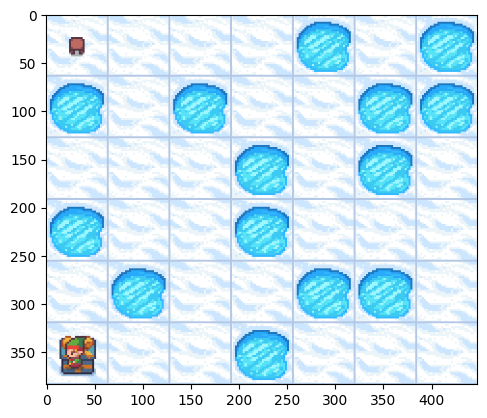

Episode: 5 done with total_rewards: 1.0


In [10]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(5):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state, :])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        time.sleep(0.3)

### Each value in a list is the quality of action based on and as it increases so the agent learnt to follow the increased value pattern that get it to the reward (G)

### The agent follows higher Q-values to reach the goal efficiently.

### Negative values (-0.023351, -0.017680, etc.) indicate penalties, meaning the agent should avoid those paths if possible.

### The goal state (G) is always 0.0000 because there's no reward after reaching the goal.